In [150]:
import re
import pandas as pd

from enum import Enum

# TODO: Make do time series analysis
# TODO: Make a class instead that lets us filter by dates/date ranges, recognition vs execution, etc...
# and gives a breakdown of the stats for each PLL/OLL cases, etc...

class Mode(Enum):
    TOTAL = "both"
    RECOGNITION = "recognition"
    EXECUTION = "execution"

time_suffix = {
    Mode.TOTAL: "_time",
    Mode.RECOGNITION: "_recognition_time",
    Mode.EXECUTION: "_execution_time",
}

def make_table(csv, mode=Mode.TOTAL):
    df = pd.read_csv(csv)

    # Create a dictionary to store the execution times for each step
    execution_times = {}

    # Iterate over the columns in the dataframe
    for col in df.columns:
        if "step_" in col and time_suffix[mode] in col:
            step_name = col.replace(time_suffix[mode], "_name")
            if step_name in df.columns:
                execution_times[df[step_name][0]] = df[col]

    return pd.DataFrame.from_dict(execution_times, orient="columns")


def make_stat_table(df):
    return pd.DataFrame(
        {
            "Arithmetic Mean (ms)": df.mean(),
            "Weight": df.sum() / df.sum().sum(),
            "Weighted Mean (ms)": (df.sum() / df.sum().sum()) * df.mean(),
            "Std Dev (ms)": df.std(),
            "P50 (ms)": df.quantile(0.5),
            "P95 (ms)": df.quantile(0.95),
            "Min (ms)": df.min(),
            "Max (ms)": df.max(),
        }
    )


def stack_rank(df, column):
    sorted_df = df.sort_values(by=column, ascending=False)[[column]]
    total = sorted_df[column].sum()
    unitless_column = re.sub(r" \(.*\)", "", column)
    sorted_df[f"{unitless_column} Impact (%)"] = sorted_df[column] / total
    sorted_df[f"Cumulative {unitless_column} Impact (%)"] = sorted_df[
        f"{unitless_column} Impact (%)"
    ].cumsum()
    return sorted_df


# Ignoring recognition time since that will improve without focused effort (I think)
df = make_table("solves.csv", mode=Mode.EXECUTION)
stat_df = make_stat_table(df)
stat_df

,Arithmetic Mean (ms),Weight,Weighted Mean (ms),Std Dev (ms),P50 (ms),P95 (ms),Min (ms),Max (ms)
Cross,12172.181818,0.179908,2189.866833,3560.646313,12454.0,17081.0,6846,17098
F2L Slot 1,8920.181818,0.131842,1176.056692,5880.794025,6645.0,19035.0,3112,19350
F2L Slot 2,11127.636364,0.164469,1830.150035,9242.649764,9184.0,26777.0,3610,36336
F2L Slot 3,9392.272727,0.138820,1303.833796,4507.083826,9929.0,14976.5,790,15280
F2L Slot 4,7193.090909,0.106315,764.736717,3917.066082,7552.0,12366.0,1128,12613
EOLL,2851.818182,0.042150,120.205548,2911.212147,1800.0,8167.0,1515,10950
OCLL,4880.272727,0.072131,352.021371,3011.172499,4213.0,9777.0,1700,10936
CPOLL,4712.000000,0.069644,328.164356,3582.326702,3952.0,10953.0,0,11528
EPLL,6408.545455,0.094720,607.015502,3452.244440,6991.0,10840.0,0,11512


In [151]:
# Optimizing for P95 means we take into account our improvement over time
# and are less penalized for when we had a really bad day.
# To maximize effectiveness, focus on the steps that have the highest cumulative impact.
# TODO: Add expected improvement (Gather WCA stats, decide on a percentile to target, e.g. p50 = I want to be better than 50% of competitive cubers)
# NOTE: Probably need to do this for different solve methods (CFOP w/ 4LLL, etc...)
# TODO: Add difficulty rating (e.g. number of cases to remember, time to learn)
# TODO: Calculate % of total effort
# TODO: Calculate % of total improvement
# TODO: Calculate the difficulty-adjusted-impact and stack rank by that
# TODO: Read off the values: "X% of effort gives Y% of improvement"
stack_rank(stat_df, column="P95 (ms)")

,P95 (ms),P95 Impact (%),Cumulative P95 Impact (%)
F2L Slot 2,26777.0,0.206021,0.206021
F2L Slot 1,19035.0,0.146454,0.352475
Cross,17081.0,0.131420,0.483895
F2L Slot 3,14976.5,0.115228,0.599123
F2L Slot 4,12366.0,0.095143,0.694266
CPOLL,10953.0,0.084272,0.778538
EPLL,10840.0,0.083402,0.861940
OCLL,9777.0,0.075224,0.937164
EOLL,8167.0,0.062836,1.000000


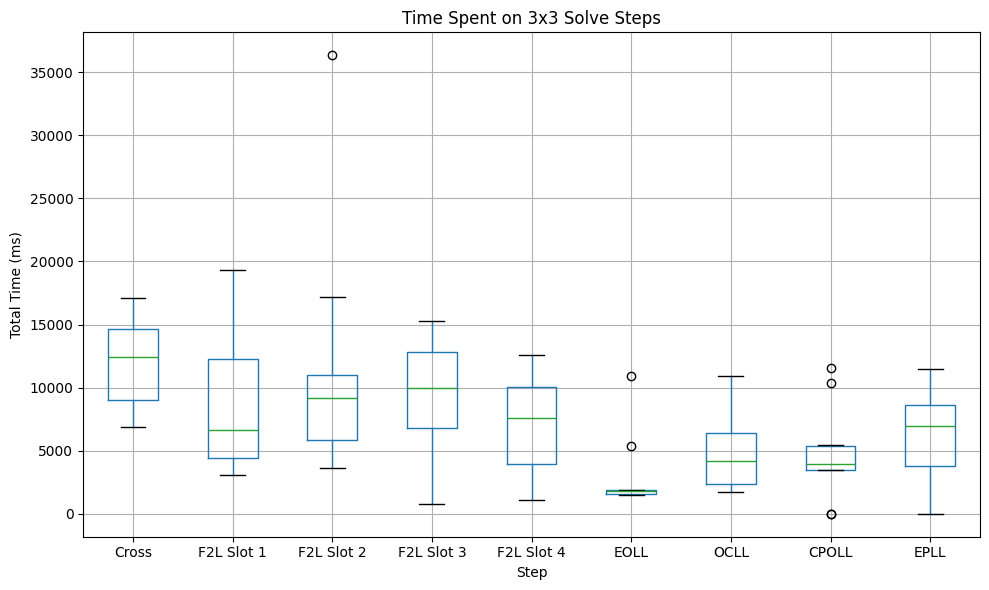

"\nWhat to look at:\n- Median (Green line)  -> Improve your expected time\n- IQR (Box length)     -> Improve your consistency\n- 1.5 x IQR (Whiskers) -> Improve your range\n- Outliers (circles)   -> Improve your really bad days\n\nRecommendation: Focus on consistency and expected time. Ignore outliers.\nRationale: This will let you solve faster and more consistently. It's hard to control your luck.\n"

In [152]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a box plot for each step
df.boxplot(ax=ax)

# Add title and axis labels
ax.set_title("Time Spent on 3x3 Solve Steps")
ax.set_xlabel("Step")
ax.set_ylabel("Total Time (ms)")

# Show the plot
plt.tight_layout()
plt.show()

"""
What to look at:
- Median (Green line)  -> Improve your expected time
- IQR (Box length)     -> Improve your consistency
- 1.5 x IQR (Whiskers) -> Improve your range
- Outliers (circles)   -> Improve your really bad days

Recommendation: Focus on consistency and expected time. Ignore outliers.
Rationale: This will let you solve faster and more consistently. It's hard to control your luck.
"""